# Demo: Computing CCD Offset 

This notebook explains the analysis of the spot data runs 13229, 13228, 13227 centering a the spot grid between two sensors. 

The output collection of the grid solutions is `u/jesteves/2023.06.12/test_b`

Author: Johnny Esteves\
Date Created: July 19, 2024

# Ratioanale

The CCD positions in the focal plane might be displaced during the warming up and cooling of the camera. Their relative distances can be significantly different. These displacements should be known to have an astrometric solution. 

Our goal is to measure the relative position of each CCD and provide an initial table for the CCD locations. 

The aim of this notebooks is to briefly describe the data and present the analysis step by step. These steps include:
* Run the DM pipeline to measure the spot position and grid solution (center, angle)
* Compute the CCDs relative displacements based on the grid offset.
* Produce an output table with the grid center, grid angle, CCD pairs, CCD pair offset


In [1]:
! eups list -s lsst_distrib

   g047143d79e+efab7f3517 	current w_2024_29 setup


In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from astropy.stats import sigma_clip
from scipy.stats import skew
from matplotlib.patches import Rectangle

import lsst.afw.display as afwDisplay
from astropy.visualization import imshow_norm, MinMaxInterval,AsinhStretch,LinearStretch,SqrtStretch,ContrastBiasStretch,ZScaleInterval,AsymmetricPercentileInterval,ManualInterval

# from myutils import *

In [3]:
import seaborn as sns
sns.set_context('talk')

# Experiment Setup

The data consists of exposures with a spot grid mask between two CCDs. 

### Raw Image

Example from CCS, Grid on detectors: 32, 31 with expId = 177

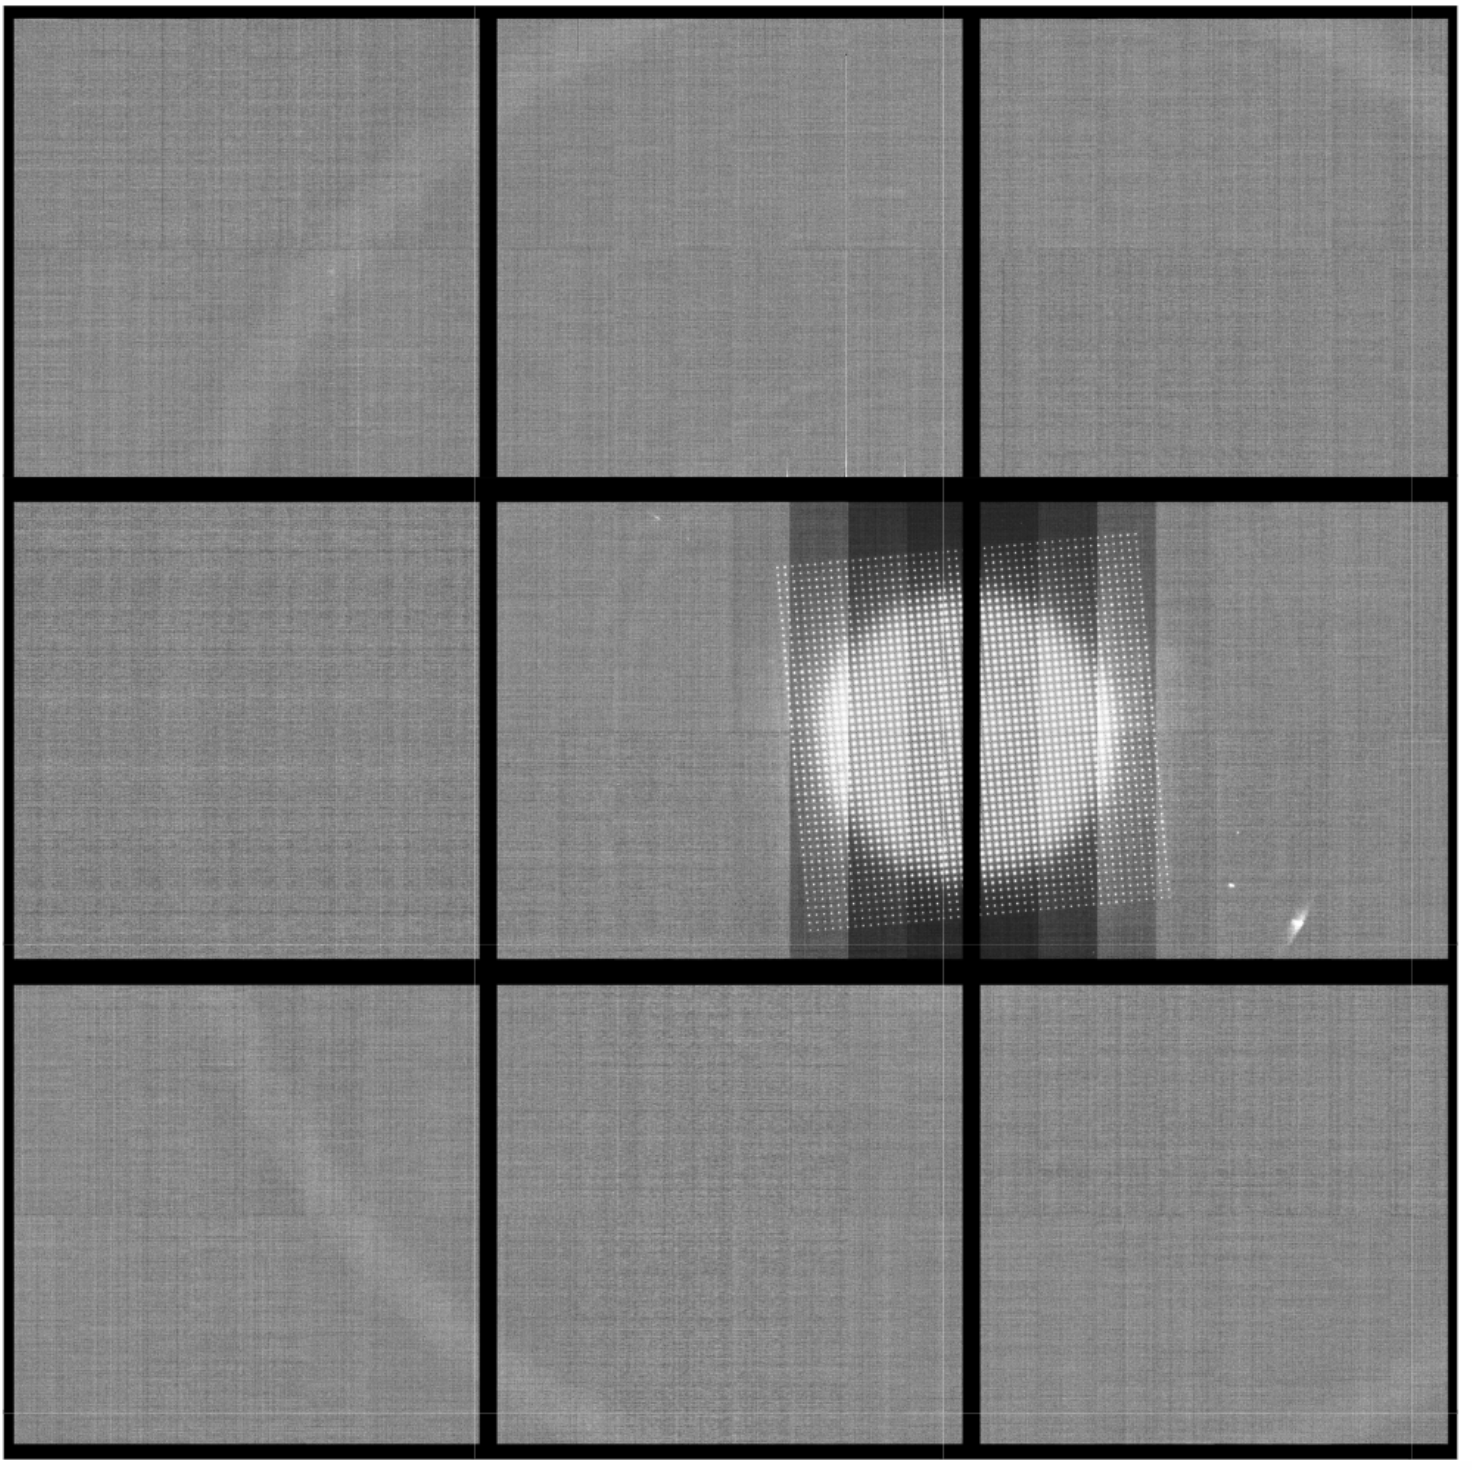

# 1 - Make Grid Measurements

The first step is to run the DM pipeline with the `spots.yaml` config file. This configuration file includes the tasks: `isr`, `characterizeSpots` and `gridFit`. The last two tasks were created specially to handle the spot data. A description of these tasks you can find on Esteves et al. 2024

### DM Script Used

We run the script on usdf. The bash file used here is presented below. To run your own task you should modify the `CONFIG` and the output collection name.

```
#!/bin/bash

##SBATCH --partition=rubin
#SBATCH --job-name=calib1
#SBATCH --output=/sdf/group/rubin/user/esteves/github/slacSummer2023/ccd-spacing/log/all-out.txt
#SBATCH --error=/sdf/group/rubin/user/esteves/github/slacSummer2023/ccd-spacing/log/all-err.txt
#SBATCH --ntasks=16
#SBATCH --cpus-per-task=8
#SBATCH --mem-per-cpu=3G
#SBATCH --time=24:00:00

source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2023_22/loadLSST-ext.bash
setup lsst_distrib

export PYTHONPATH="/sdf/group/rubin/user/esteves/github/mixcoatl/python:${PYTHONPATH}" # Needed for using gridFit
 
# Set up repositories for collections
export REPO=/sdf/group/rubin/repo/main/
export CONFIG=/sdf/group/rubin/user/esteves/github/slacSummer2023/ccd-spacing/
export SBIAS=u/cslage/calib/13144/bias_20211229
export SDARK=u/cslage/calib/13144/dark_20211229
export DEFECTS=u/cslage/calib/13144/defects_20211229


## Run tasks
pipetask run \
        -j 16 \
        -d "instrument='LSSTCam' AND exposure.observation_type='spot' AND exposure.science_program IN ('13227', '13229') AND detector not in (189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205)" \
        -b ${REPO} \
        -i LSSTCam/calib,LSSTCam/raw/all \
        -o u/jesteves/2023.06.12/test_b \
        -p ${CONFIG}/spots.yaml \
        --skip-existing \
        --extend-run \
        --clobber-outputs \
        --register-dataset-types 
        
echo "Hey I finished"
```

## Take a look at the output

In [4]:
from lsst.daf.butler import Butler
repo = '/sdf/group/rubin/repo/main/butler.yaml'
collections = 'u/jesteves/2023.06.12/test_b'
butler = Butler(repo,collections=collections)
registry = butler.registry

In [5]:
### check repo
for dtype in registry.queryDatasetTypes():
    try:
        datasetRefs = list(registry.queryDatasets(datasetType=dtype,collections=collections))
        if len(datasetRefs)>1:
            print(len(datasetRefs), dtype)
    except:
        i=1

6188213 DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)
378 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
378 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
378 DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
378 DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
2 DatasetType('packages', {}, Packages)
26568 DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)
26568 DatasetType('isr_metadata', {band, instrument, day_obs, detector, group, physical_filter, exposure}, PropertySet)
2 DatasetType('isr_config', {}, Config)
378 DatasetType('linearizer', {instrument, detector}, Linearizer, isCalibration=True)
26568 DatasetType('isr_log', {band, instrument, day_obs, detector, group, physical_filter, exposure}, ButlerLogRecords)
2 DatasetType('gridFit_config

### Repo Stats

In [6]:
kwargs={
"datasetType": "gridSpotSrc",
"collections": collections,
"where":
"""
instrument='LSSTCam' and
exposure.science_program in ( '13229' )
"""
}

_datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(_datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 6497 in this repository with the condition supplied {'datasetType': 'gridSpotSrc', 'collections': 'u/jesteves/2023.06.12/test_b', 'where': "\ninstrument='LSSTCam' and\nexposure.science_program in ( '13229' )\n"}


In [7]:
nall = len(_datasetRefs)
nimages_per_det = np.round(nall/189,2)
print(f'There is in average {nimages_per_det} images per detector')

There is in average 34.38 images per detector


Too low! Each grid should have at least 1000 sources

### Selecting only images with grid

For a given raft all detectors had imaged read-out. However, only two have a grid on them. Selecting by the number of sources gives us the images with the spot grid.

In [8]:
nsrcs = []
datasetRefs = []
nSrcs = []
print('Number of sources inside grid spot catalog')
print('A common half grid should have at least 1000 spots')
print('Starting Loading the Catalogs') 
for i,dR in enumerate(_datasetRefs):
    cat = butler.get('gridSpotSrc',dR.dataId).asAstropy()
    # print('Reading %i/%i - size: %i'%(i,nall,len(cat)))
    nSrcs.append(len(cat))

# select only the half-grid images
sel = np.where(np.array(nSrcs)>700)[0]
datasetRefs = [_datasetRefs[i] for i in sel]
print(f'You have {sel.size} spot catalogs with half-grid')

Number of sources inside grid spot catalog
A common half grid should have at least 1000 spots
Starting Loading the Catalogs
You have 701 spot catalogs with half-grid


### Take a look at the grids

In [9]:
def plot_image_cat(img, cat, axs=None, vmin=-5, vmax=50):
    if axs is None: axs = plt.gca()
    x,y=cat.asAstropy()['base_SdssCentroid_x'],cat.asAstropy()['base_SdssCentroid_y']
    axs.scatter(x,y,s=1,color='r',alpha=0.5)
    common={
        "vmin": vmin,
        "vmax": vmax
        #"norm": "asinh"
    }
    p = axs.imshow(img.image.array,cmap="gray",origin="lower",**common)
    axs.set_title('ExpId = %i'%img.visitInfo.getId(), fontsize=12)
    return p

In [10]:
detectorIds = np.array([int(datasetRefs[i].dataId['detector']) for i in range(len(datasetRefs))])
spots = np.where(detectorIds==32)[0]

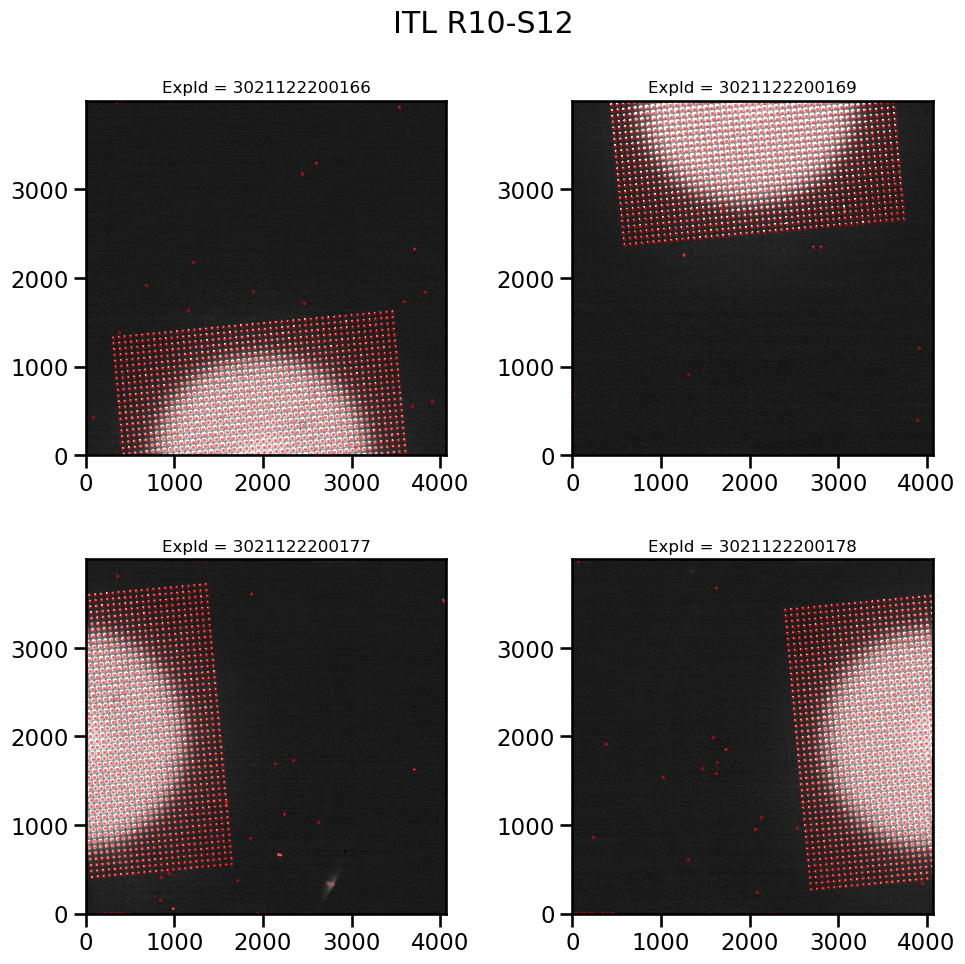

In [11]:
fig,axs = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

axs = axs.flatten()
for i,si in enumerate(spots):
    img = butler.get('postISRCCD',datasetRefs[si].dataId)
    cat = butler.get('spotSrc',datasetRefs[si].dataId)
    plot_image_cat(img, cat, axs=axs[i])

fig.suptitle('ITL R10-S12')
fig.tight_layout()
fig.savefig('run13229_det32_array.png',dpi=120)

In [12]:
cat

<class 'lsst.afw.table.SourceCatalog'>
 id  coord_ra ... base_ClassificationExtendedness_flag base_FootprintArea_value
       rad    ...                                                pix           
---- -------- ... ------------------------------------ ------------------------
   1      nan ...                                 True                      207
   2      nan ...                                 True                      226
   3      nan ...                                 True                      188
   4      nan ...                                 True                      226
   5      nan ...                                 True                      207
   6      nan ...                                 True                      226
   7      nan ...                                 True                      226
   8      nan ...                                 True                      169
   9      nan ...                                 True                      169
 

# 2 - Grid Solution

Here, we build a grid catalog with grid position (X0, Y0, theta),  where theta is the grid orientation. Also, each half-grid has its own pair, we find the grid pairs based on the expID. 

In [13]:
from collections import Counter
def find_pairs(a):
    pairExpId = [item for item, count in Counter(a).items() if count > 1]
    pairs = [np.where(a==expid)[0] for expid in pairExpId]
    return pairs

def get_pairs(a):
    pairs = find_pairs(a)
    # join repeated ids in the same id
    pairID = np.full(sel.size,-1,dtype=np.int64)
    for i in range(len(pairs)):
        for ix in pairs[i]:
            pairID[ix] = i
    return pairID

In [14]:
from astropy.table import Table

info = dict.fromkeys(['objID','pairID','expID','detector','ccd_type'])
info['objID'] = np.arange(sel.size,dtype=np.int16)
info['detector'] = np.array([datasetRefs[i].dataId['detector'] for i in range(sel.size)])
info['expID'] = np.array([datasetRefs[i].dataId['exposure'] for i in range(sel.size)],dtype=np.int64)
info['ccd_type'] = np.array([butler.get('raw.metadata',datasetRefs[i].dataId).toDict()['CCD_MANU'] for i in range(sel.size)])
info['pairID'] = get_pairs(info['expID'])
# info['pairID'] = find_pairs(info['expID'])
info = Table(info)

In [15]:
grid_cols = ['GRID_X0', 'GRID_X0ERR', 'GRID_Y0', 'GRID_Y0ERR', 'GRID_THETA', 'GRID_THETAERR','FIT_CHISQR','FIT_REDCHI']

def get_grid_fit(dR):
    md = butler.get('gridSpotSrc',dR.dataId).getMetadata().toDict()
    if md['FIT_SUCCESS']:
        return {col:md[col] for col in grid_cols}
    else:
        return {col:np.nan for col in grid_cols}

def get_grid_results(expids):
    out = Table(names=grid_cols)
    for exp in expids:
        vals = get_grid_fit(exp)
        out.add_row(vals)
    out['objID'] = np.arange(len(expids),dtype=np.int16)
    return out

griD = get_grid_results(datasetRefs)

In [16]:
def clean(data, th=0.1):
    arr = np.array(data_all['FIT_REDCHI'])
    xlo, xhi = np.nanpercentile(arr, [16,84])
    xm = xhi + 1.5*(xhi-xlo)
    return data[arr<xm]


In [17]:
# butler.get('gridSpotSrc',datasetRefs[0].dataId).getMetadata().toDict()

In [18]:
from astropy.table import join
data_all = join(info,griD,keys='objID')

# clean data with bad grid solutions
data = clean(data_all)
data

<Table length=627>
objID pairID     expID     ...    FIT_CHISQR        FIT_REDCHI    
int16 int64      int64     ...     float64           float64      
----- ------ ------------- ... ---------------- ------------------
    0      0 3021122200113 ... 153.272280781956  0.150119765702209
    1      1 3021122200122 ... 323.660982996923  0.306497142989511
    3      1 3021122200122 ... 155.252617655372  0.131014867219723
    4      3 3021122200123 ... 246.951351695471  0.221879022188204
    5      4 3021122200115 ... 115.630853259028  0.106278357774842
    6      3 3021122200123 ... 157.111092298657  0.134053833019331
    7      5 3021122200124 ... 257.358007430105  0.228356705794237
    8      0 3021122200113 ... 192.351764499295  0.170675922359623
    9      6 3021122200116 ... 122.922371531427  0.109850197972679
   10      7 3021122200125 ... 254.610231514133  0.230834298743548
  ...    ...           ... ...              ...                ...
  690    330 3021122200450 ... 215.855779847651  0.184649939989437
  691     -1 3021122200453 ... 169.023713308237  0.109117955654123
  692    333 3021122200457 ... 153.054090368012  0.136169119544495
  693    335 3021122200458 ... 266.439132107506  0.226949856991061
  694    334 3021122200459 ... 40.3337772694395 0.0557096371124855
  695    336 3021122200460 ... 76.6775498869635  0.100891513009162
  697     -1 3021122200454 ... 175.227319713143  0.113636394107096
  698    335 3021122200458 ...  166.58290292745  0.151164158736343
  699    336 3021122200460 ... 46.7537111357138 0.0662233868777815
  700     -1 3021122200488 ... 223.515983724359  0.209677283043489

Each row in the data is an unique exposureID and detector. Each detector should have between 2 to 6 exposures associated with, this number depends on the number of neighbours. 

### Visualize the Grid Solution

In [19]:
from sklearn.cluster import KMeans
# Create a KMeans instance with 5 clusters
kmeans = KMeans(n_clusters=5)

# Fit the data to the K-means model
pos = np.c_[data['GRID_X0'],data['GRID_Y0']]
kmeans.fit(pos)

# Get the cluster labels for each data point
labels = kmeans.labels_

data['group'] = labels
data['orientation'] = 180-np.arctan2(pos[:,1]-2000.,pos[:,0]-2000.)*180./np.pi

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


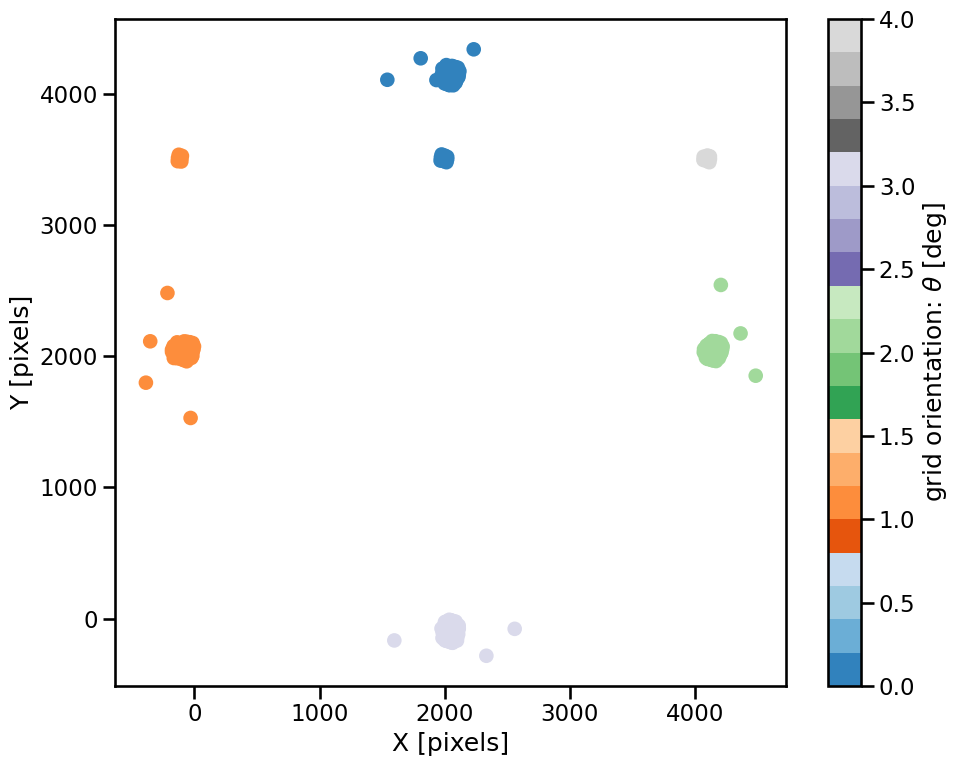

In [20]:
plt.figure(figsize=(10,8))
plt.scatter(data['GRID_X0'],data['GRID_Y0'],c=data['group'],cmap='tab20c')
plt.colorbar().set_label(r'grid orientation: $\theta$ [deg]')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.tight_layout()

# 3 - Convert Grid Position to Focal Plane Coord. System

We compute the CCD offsets in the focal plane coordinates systems:

$$
\delta x \,[mm] ={\rm grid}_a(x) - {\rm grid}_b(x)
$$

where $x$ is a vector in the focal plane coordinate system. 
The grid postion provided by `gridFitTask` is in pixel in the detector coordinates system, so to convert to ${\rm grid}(x)$ we have:

$$
{\rm grid}(x) = x_{\rm cen}({\rm pixel}) \times \text{pixel-size} + CCD(x)
$$

With the relative distance from the grid measurement in pixels: $x_{\rm cen}({\rm pixel}) = GridCen(xpixel) - CCD(xpixel)$. The same goes for the y-component.

The grid angle measured in a detector pair a can be slightly different from the same angle measured in b. 

$$
\delta \theta = {\rm grid}_a(\theta) - {\rm grid}_b(\theta)
$$

The offset between the angles indicates that there are displacements in rotation between  the two detectors. 

In [21]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_nums = {det.getName():i for i, det in enumerate(camera)}

print(det_names[98],det_nums['R22_S22'])

R22_S22 98


In [22]:
from lsst.afw.cameraGeom import FOCAL_PLANE, FIELD_ANGLE, PIXELS
det = camera[98]
print(f"{det.getCenter(FIELD_ANGLE) = } (radians)")
print(f"{det.getCenter(FOCAL_PLANE) = } (mm)")

det.getCenter(FIELD_ANGLE) = Point2D(0.0040977554376279432, 0.0040977554376279432) (radians)
det.getCenter(FOCAL_PLANE) = Point2D(42.25, 42.25) (mm)


In [23]:
## Convert to focal plane coords.
# from astropy.io.ascii import read
# data = read('fullRun-2023-06-21.csv')

to_mm = 1./100.

# in mm
data['X0_CCD'] = [camera[int(di)].getCenter(FOCAL_PLANE)[0] for di in data['detector']]
data['Y0_CCD'] = [camera[int(di)].getCenter(FOCAL_PLANE)[1] for di in data['detector']]

# in pixels
data['X0_CCD_PIXEL'] = [camera[int(di)].getCenter(PIXELS)[0] for di in data['detector']]
data['Y0_CCD_PIXEL'] = [camera[int(di)].getCenter(PIXELS)[1] for di in data['detector']]

# put the center on the CCD coordinate system (middle-point)
dx_pixel = data['GRID_X0'] - data['X0_CCD_PIXEL']
dy_pixel = data['GRID_Y0'] - data['Y0_CCD_PIXEL']

# grid center position on the focal coordinate system
data['GRID_X0_FOCAL_PLANE'] = dx_pixel*to_mm + data['X0_CCD']
data['GRID_Y0_FOCAL_PLANE'] = dy_pixel*to_mm + data['Y0_CCD']

# 4 - Compute CCD Spacing

In [24]:
## For each exposure 
detectors = data['detector']
pairs = data['pairID']

deltax, deltay, deltat = [], [], []
for i in range(len(data)):
    did = detectors[i]
    # pick a pair
    pid = pairs[i]
    mask = pairs==pid
    if np.count_nonzero(mask)==2:
        # get the pair indexes
        m0 = mask&(detectors==did)
        m1 = mask&(detectors!=did)
        
        # print(data[['pairID','detector','GRID_X0_FOCAL_PLANE','GRID_Y0_FOCAL_PLANE']][mask])
        dx = float(data['GRID_X0_FOCAL_PLANE'][m0]-data['GRID_X0_FOCAL_PLANE'][m1])
        dy = float(data['GRID_Y0_FOCAL_PLANE'][m0]-data['GRID_Y0_FOCAL_PLANE'][m1])
        dt = float(data['GRID_THETA'][m0]-data['GRID_THETA'][m1])
    else:
        dx = dy = dt = np.nan
        
    deltax.append(dx)
    deltay.append(dy)
    deltat.append(dt)

deltax = np.array(deltax)
deltay = np.array(deltay)
deltat = np.array(deltat)

In [25]:
data['CCD-SPACING-X'] = deltax
data['CCD-SPACING-Y'] = deltay
data['CCD-SPACING-THETA'] = deltat*180*60/np.pi # in arcmin

In [26]:
np.count_nonzero(np.isnan(data['CCD-SPACING-X']))

91

In [27]:
from datetime import date
current_date = date.today()

data.write(f'fullRun-{current_date}.csv',overwrite=True)
print(f'Table saved: fullRun-{current_date}.csv')

Table saved: fullRun-2024-07-19.csv


In [28]:
np.nanstd(data['CCD-SPACING-Y'])

0.0417090420732103

# 5 - Visualize Results

In [29]:
def get_label(x, units='pixel'):
    return r'$\sigma: %.2f$ %s'%(np.nanstd(x), units)

In [30]:
## Outliers
dR = np.hypot(data['CCD-SPACING-X'],data['CCD-SPACING-Y'])
xlo, xhi = np.nanpercentile(dR, [16,84])
xm = xhi + 1.5*(xhi-xlo)
outliers = dR>xm
xm

0.1722009942456007

In [31]:
np.count_nonzero(outliers)

4

In [32]:
colors = ['lightgray','k','r']
itl = data['ccd_type'] == 'ITL'
e2v = ~itl

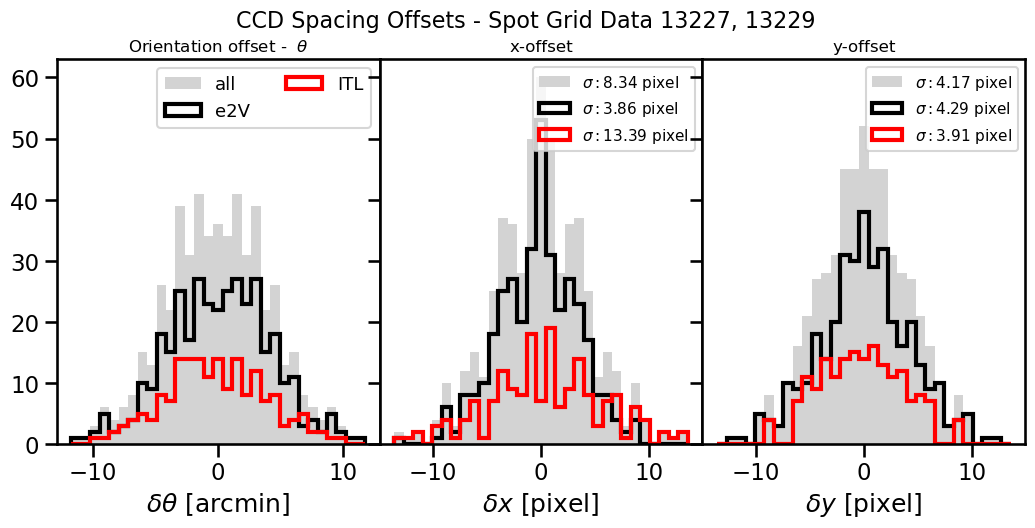

In [33]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(12.5,5), sharey='all')
fig.subplots_adjust(wspace=0.0)

_ = axs[1].hist(deltax[~outliers]/to_mm,bins=31, color=colors[0],label=get_label(deltax/to_mm))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[1].hist(deltax[e2v]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltax[e2v]/to_mm))
_ = axs[1].hist(deltax[itl]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltax[itl]/to_mm))


_ = axs[2].hist(deltay/to_mm,bins=_[1], color=colors[0],label=get_label(deltay/to_mm))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[2].hist(deltay[e2v]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltay[e2v]/to_mm))
_ = axs[2].hist(deltay[itl]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltay[itl]/to_mm))

_ = axs[0].hist(deltat*180*60/np.pi, bins=31, color=colors[0],label='all')
_ = axs[0].hist(deltat[e2v]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[1],label='e2V')
_ = axs[0].hist(deltat[itl]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[2],label='ITL')

axs[0].legend(loc=1,fontsize=13, ncol=2)
axs[1].legend(loc=1,fontsize=11)
axs[2].legend(loc=1,fontsize=11)

axs[1].set_xlabel(r'$\delta x$ [pixel]')
axs[2].set_xlabel(r'$\delta y$ [pixel]')
axs[0].set_xlabel(r'$\delta \theta$ [arcmin]')
# axs[1].set_xticks(np.linspace(-12,12,3))
# axs[2].set_xticks(np.linspace(-12,12,3))


fig.suptitle(r'CCD Spacing Offsets - Spot Grid Data 13227, 13229', fontsize=16)
axs[1].set_title('x-offset', fontsize=12)
axs[2].set_title('y-offset', fontsize=12)
axs[0].set_title(r'Orientation offset -  $\theta$', fontsize=12)
# fig.tight_layout()
plt.savefig(f'histogram_ccd_offsets_{current_date}.png',dpi=150, bbox_inches = 'tight')

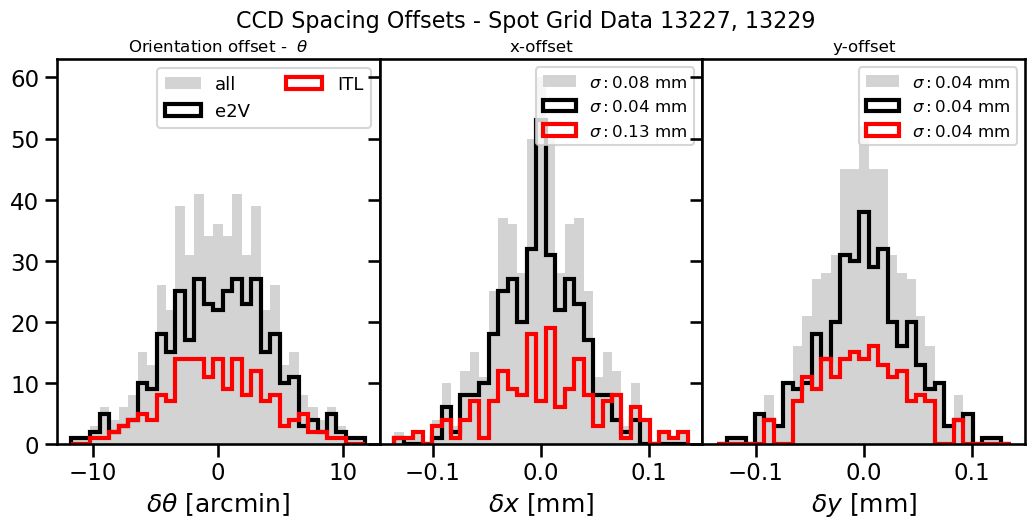

In [34]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(12.5,5), sharey='all')
fig.subplots_adjust(wspace=0.0)

_ = axs[1].hist(deltax[~outliers], bins=31, color=colors[0],label=get_label(deltax, units='mm'))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[1].hist(deltax[e2v], bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltax[e2v], units='mm'))
_ = axs[1].hist(deltax[itl], bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltax[itl], units='mm'))


_ = axs[2].hist(deltay,bins=_[1], color=colors[0],label=get_label(deltay, units='mm'))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[2].hist(deltay[e2v], bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltay[e2v], units='mm'))
_ = axs[2].hist(deltay[itl], bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltay[itl], units='mm'))

_ = axs[0].hist(deltat*180*60/np.pi, bins=31, color=colors[0],label='all')
_ = axs[0].hist(deltat[e2v]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[1],label='e2V')
_ = axs[0].hist(deltat[itl]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[2],label='ITL')

axs[0].legend(loc=1,fontsize=13, ncol=2)
axs[1].legend(loc=1,fontsize=12)
axs[2].legend(loc=1,fontsize=12)

axs[1].set_xlabel(r'$\delta x$ [mm]')
axs[2].set_xlabel(r'$\delta y$ [mm]')
axs[0].set_xlabel(r'$\delta \theta$ [arcmin]')
# axs[1].set_xticks(np.linspace(-15*to_mm,15*to_mm,5))
# axs[2].set_xticks(np.linspace(-15*to_mm,15*to_mm,5))


fig.suptitle(r'CCD Spacing Offsets - Spot Grid Data 13227, 13229', fontsize=16)
axs[1].set_title('x-offset', fontsize=12)
axs[2].set_title('y-offset', fontsize=12)
axs[0].set_title(r'Orientation offset -  $\theta$', fontsize=12)
# fig.tight_layout()
plt.savefig(f'histogram_ccd_offsets_{current_date}_mm.png',dpi=150, bbox_inches = 'tight')

### Outliers

In [35]:
data[['pairID','expID','detector','ccd_type','CCD-SPACING-X','CCD-SPACING-Y','CCD-SPACING-THETA']][outliers]

<Table length=4>
pairID     expID     detector ...     CCD-SPACING-Y     CCD-SPACING-THETA 
int64      int64      int64   ...        float64             float64      
------ ------------- -------- ... --------------------- ------------------
   138 3021122200251       72 ...  -0.08701479941327861 -5.335996217469593
   138 3021122200251       75 ...   0.08701479941327861  5.335996217469593
   274 3021122200379      143 ...  0.004225999135059055  2.634233195266649
   274 3021122200379      173 ... -0.004225999135059055 -2.634233195266649

In [36]:
np.array(np.unique(data[outliers]['detector']))

array([ 72,  75, 143, 173])

In [37]:
xm/to_mm

17.22009942456007

In [38]:
dR[outliers]/to_mm

<Column name='CCD-SPACING-X' dtype='float64' length=4>
115.50605050674965
115.50605050674965
22.809127325493865
22.809127325493865

In [39]:
len(np.unique(data['detector']))

177

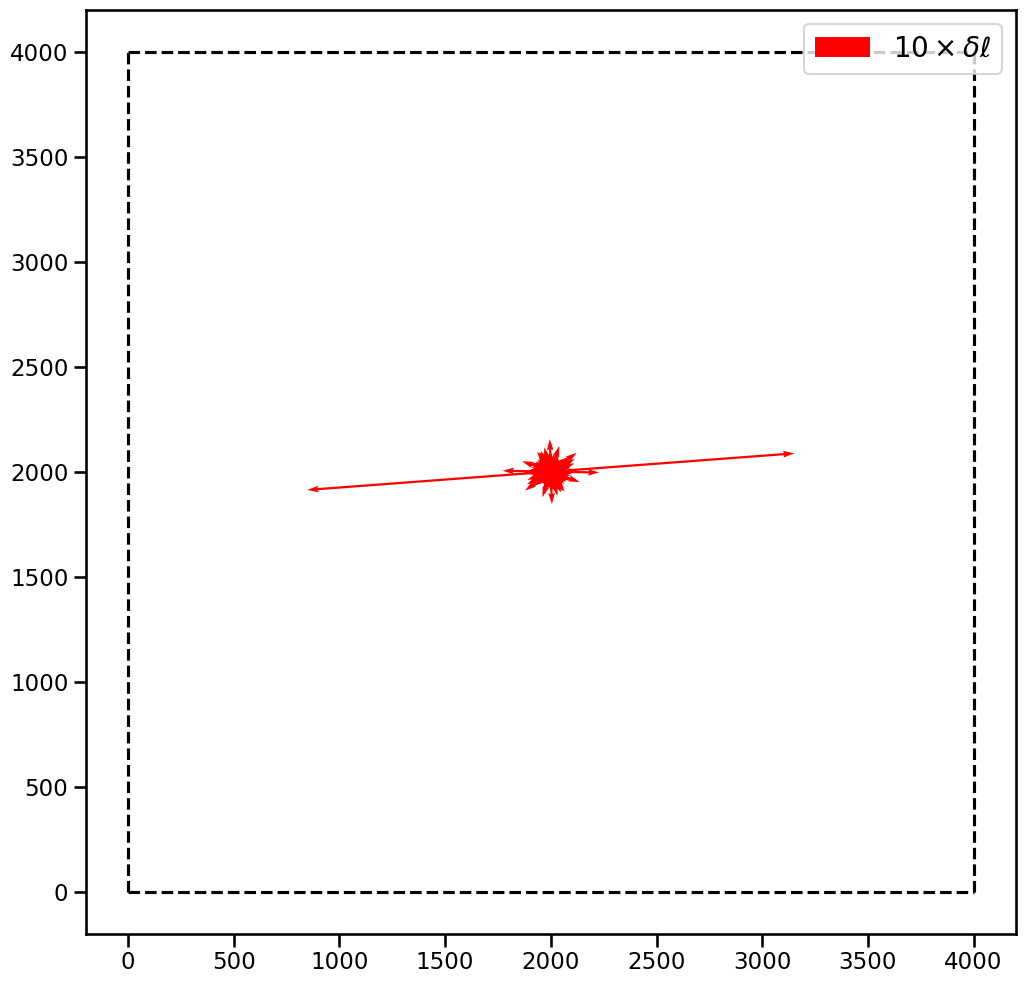

In [40]:
# print(det_names[98],det_nums['R22_S22'])
plt.figure(figsize=(12,12))
di = det_nums['R22_S22']
X = np.array(data['GRID_X0'])
Y = np.array(data['GRID_Y0'])

dx = deltax/to_mm
dy = deltay/to_mm
plt.quiver(np.zeros_like(dx)+2000, np.zeros_like(dx)+2000, dx, dy, color='r', scale=1/10., scale_units='xy', angles='xy', label=r'$10 \times \delta \ell$')

plt.plot([0,4000],[0,0],'k--')
plt.plot([0,4000],[4000,4000],'k--')
plt.plot([0.,0.],[0,4000],'k--')
plt.plot([4000.,4000.],[0,4000],'k--')
plt.legend(loc=1, fontsize=20)